## 2. Eigengesichter

Die Hauptkomponentenanalyse lässt sich auch auf Bilder anwenden, indem man die Bildzeilen in einem einzigen Vektor aneinander hängt (Stacking). Die zugehörigen Richtungen extremaler Varianz heißen Eigengesichter. Sie eignen sich nicht nur zur Datenkompression, sondern auch zum Aufbau eines einfachen Gesichtserkennungssystems (s. M. Turk and A. Pentland, “Eigenfaces for Recognition”, Journal of Cognitive Neuroscience, vol. 3, no. 1, pp. 71–86, 1991). Für die Funktion eines solchen Systems ist es wichtig, dass die Gesichter zentriert und in derselben Größe abgebildet sind. Ein dafür geeigneter Datensatz ist ''Labeled Faces in the Wild'' der Universität von Massachusetts in Amherst (http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz, 233MB) mit Bildern von 13.000 Personen des öffentlichen Lebens aus dem Internet, alle mit Namen gelabelt.

### a)
Laden Sie sich den oben angegebenen Datensatz herunter. Erstellen Sie ein Python- Skript, dass die Verzeichnisse des Datensatzes durchsucht und die Personen ermittelt, für die mindestens 70 Bilder existieren. Die dafür geeigneten Funktionen finden sich im Standardmodul os bzw. os.path.


In [1]:
import os
import urllib.request
import urllib
import tarfile

from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
DATA_LOADING = False

In [3]:
if DATA_LOADING:
    Path("data/faces_in_the_wild").mkdir(parents=True, exist_ok=True)

    urllib.request.urlretrieve("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", "data/lfw-funneled.tgz")

In [4]:
if DATA_LOADING:
    with tarfile.open("data/lfw-funneled.tgz") as f:
        f.extractall("./data/faces_in_the_wild/")

In [5]:
persons = []

for item in Path("./data/faces_in_the_wild/lfw_funneled/").iterdir():
    if item.is_dir():
        if len(os.listdir(item)) >= 70:
            persons.append(item.stem)

persons

['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Tony_Blair']

### b)
Erstellen Sie ein Python-Skript, das alle Bilder bis auf eines pro Person (diese werden später zum Testen des Klassifikators gebraucht) dieser am häufigsten abgebildeten Personen lädt, diese in Vektoren stackt und dann in einer gemeinsamen Designmatrix ablegt. Zum Laden der Bilder in Numpy-Arrays verwenden Sie am einfachsten das Modul scikit-image. Schneiden Sie zunächst einen einheitlichen zentralen Ausschnitt aus, der nur Augen und Mund enthält. Skalieren Sie die Bilder auf die Größe 32 × 32. Achten Sie darauf, vorher die Farbbilder in Grauwerte umzuwandeln (z.B. mit der Option as_gray = True) Legen Sie zusätzlich einen Vektor an, in dem der Name der Person (d.h. der Ordnername) für jede Zeile steht. Führen Sie die gleiche Art der Verarbeitung mit dem übrig gebliebenen Testbild pro Person durch und speichern Sie diese getrennt ab.

In [18]:
from face_vectorizer import FaceVectorizer

face_vectorizer = FaceVectorizer("./data/faces_in_the_wild/lfw_funneled/", test_size=1, crop_size=60)
train_images, test_images, train_labels, test_labels = face_vectorizer.get_images()

### c)
 Wenden Sie nun Ihre Hauptkomponentenanalyse aus Arbeitsblatt 1 auf Ihre Designmatrix (Achtung: kopieren Sie alle Trainingsbilder für alle Personen als Zeilen in eine gemeinsame Designmatrix!) an. Stellen Sie die ersten 150 Eigenwerte in einem Diagramm und die ersten 12 Eigengesichter durch Umformung der gestackten Darstellung in das ursprüngliche Bildformat dar. Interpretieren Sie das Ergebnis.

In [19]:
from pca import PCA
import numpy as np

pca = PCA(scale=True, center=True)
pca.fit(train_images)

In [8]:
# norm_imgs = train_images - np.mean(train_images, axis=0)
# norm_imgs = norm_imgs / np.std(train_images, axis=0)
# u, s, v = np.linalg.svd(norm_imgs, full_matrices=False)
#
# s = np.diag(s)
#
# missing_cols = v.shape[1] - s.shape[1]
# missing_rows = u.shape[0] - s.shape[0]
#
# s = np.hstack((s, np.zeros((len(s), missing_cols))))
#
# eigenfaces = s @ v

In [20]:
eigenfaces = pca.s @ pca.v

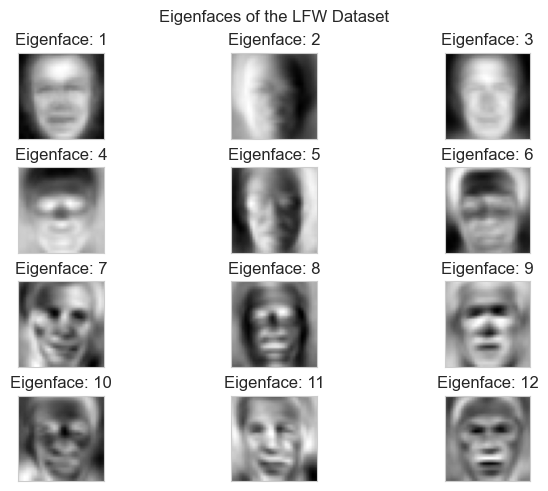

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, constrained_layout=True)

# fig.tight_layout()
fig.suptitle("Eigenfaces of the LFW Dataset")
for idx, ax in enumerate(axs.reshape(-1)):
    ax.imshow(eigenfaces[idx, :].reshape((32, 32)), cmap="gray")
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.grid(False)
    ax.set_title(f"Eigenface: {idx + 1}")

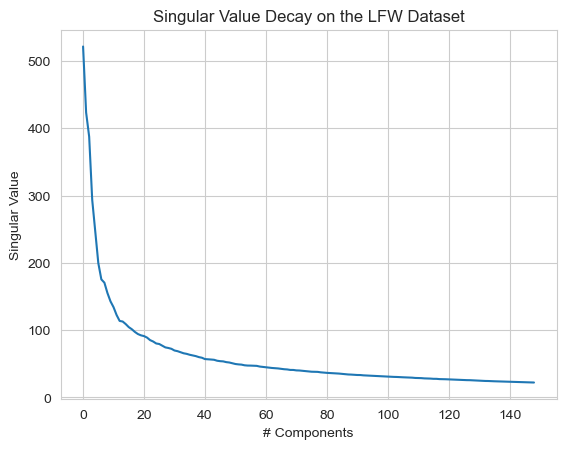

In [11]:
import matplotlib.pyplot as plt

plt.plot(
    np.diagonal(pca.s)[0:149]
)
plt.title("Singular Value Decay on the LFW Dataset")
plt.ylabel("Singular Value")
plt.xlabel("# Components");

### d)
 Von den Testbildern wird nun ebenfalls der Mittelwert der Trainingsdaten abgezogen (s. Schritt 1 im PCA-Algorithmus). Projizieren Sie jedes der Trainings- und Testbilder auf die ersten 7 Eigengesichter, d.h. Sie erhalten so für jedes Trainings- und Testbild 7 Merkmale. Die Gesichtserkennung geschieht nun dadurch, dass Sie den euklidischen Abstand des Testbildes in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern berechnen. Die Person des am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator). Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es?

In [22]:
# Projektion auf erste 7 Eigengesichter
test_projections = test_images @ eigenfaces[0:7, :].T
train_projections = train_images @ eigenfaces[0:7, :].T

In [23]:
from scipy.spatial.distance import euclidean

np.argmin(np.apply_along_axis(euclidean, axis=1, arr=train_projections, v=test_projections[5, :]))

989

In [24]:
def predict_face(img):
    y_idx = np.argmin(np.apply_along_axis(euclidean, axis=1, arr=train_projections, v=img))
    return train_labels[y_idx]

In [25]:
import pandas as pd

pd.DataFrame({"Predicted Face": np.apply_along_axis(predict_face, axis=1, arr=test_projections).tolist(),
              "Actual Face": test_labels.tolist()})

,Predicted Face,Actual Face
0,[Ariel_Sharon],[Ariel_Sharon]
1,[George_W_Bush],[Colin_Powell]
2,[George_W_Bush],[Donald_Rumsfeld]
3,[Donald_Rumsfeld],[George_W_Bush]
4,[Donald_Rumsfeld],[Gerhard_Schroeder]
5,[Gerhard_Schroeder],[Hugo_Chavez]
6,[Tony_Blair],[Tony_Blair]


In [16]:
%load_ext version_information

In [17]:
%version_information numpy, matplotlib

Software versions
Python 3.10.6 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.4.0
OS Windows 10 10.0.19044 SP0
numpy 1.23.3
matplotlib 3.5.2
Mon Nov 14 09:40:20 2022 Mitteleuropäische Zeit